In [2]:
from os import listdir
from re import match
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage

from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


The next cells gets & processes text from captcha image filenames <br/>
Also is checked that all texts use only 5 alphanumeric characters

In [3]:
images = listdir('/floyd/input/captcha')

In [4]:
len(images)

1070

In [5]:
images[0]

'd3ycn.png'

In [6]:
all([image.islower() for image in images])

True

In [7]:
all([image.endswith('.png') for image in images])

False

In [8]:
texts = [match('^([a-z0-9]+)\..+$', image).group(1) for image in images]

In [9]:
all([len(text) == 5 for text in texts])

True

In [10]:
with open('/floyd/home/texts.json', 'w') as fp:
    json.dump(texts, fp)

A single value of the target variable could be represented by a 5x36 sparse matrix
Where the ith row represents the character at the ith of position in the text. <br/>
On each row, only 1 column will be set to 1. The rest will be 0s
If the columnd index of the element set to 1 is between 0 and 25, the character will be a letter (from 'a' to 'z'), whereas if its between 26 and 35, it will be a digit(from 0 to 9)

In [11]:
chrs = np.zeros([len(texts),5], dtype=np.uint8)
for i, j in product(range(0, len(texts)), range(0, 5)):
    ch = texts[i][j]
    k = ord(ch)
    if k >= ord('a') and k <= ord('z'):
        k -= ord('a')
    else:
        k -= ord('0') - (ord('z') - ord('a') + 1)
    chrs[i, j] = k

chrs array is a nx5 array. The value at position (i, j) will be the index of the alphanumeric character (between 0 and 35) at the j-th place on the i-th text

Now we create an array 'y' of size nx5x36 where y[k, :, :] is the value for the target variable for the k-th captcha image

In [12]:
chrs[0:2,:]

array([[ 3, 29, 24,  2, 13],
       [13, 30, 23, 23, 31]], dtype=uint8)

In [13]:
y = np.zeros([len(texts), 5, 36], dtype=np.bool)

In [14]:
for i, j in product(range(0, len(texts)), range(0, 5)):
    y[i, j, :] = to_categorical(chrs[i, j], 36)

In [15]:
np.count_nonzero(y) == len(texts) * 5

True

In [18]:
y[0, 0, :].astype(np.uint8)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

Now we preprocess the captcha images

In [19]:
X = np.zeros([len(texts), 50, 200, 1], dtype=np.float32)

In [20]:
for i, image in zip(range(0, len(images)), images):
    x = skimage.io.imread('/floyd/input/captcha/' + images[0])
    assert x.shape[0:2] == (50, 200)
    X[i, :, :, :] = x[:, :, 0].reshape([50, 200, 1])

In [21]:
X[0, :, :, 0]

array([[192., 192., 192., ..., 251., 251., 251.],
       [192., 192., 192., ..., 251., 251., 251.],
       [192., 192., 192., ..., 251., 251., 251.],
       ...,
       [195., 195., 195., ..., 254., 254., 254.],
       [195., 195., 195., ..., 254., 254., 254.],
       [195., 195., 195., ..., 254., 254., 254.]], dtype=float32)

In [22]:
X.shape

(1070, 50, 200, 1)

([], <a list of 0 Text yticklabel objects>)

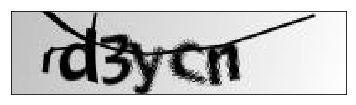

In [23]:
plt.imshow(X[0, :, :, 0] / 255, cmap='gray')
plt.xticks([])
plt.yticks([])

We normalize pixel values in the range [0, 1]

In [24]:
X /= 255

In [25]:
np.max(X), np.min(X)

(1.0, 0.0)

Now we save our results in a npy file

In [26]:
np.savez_compressed('/floyd/home/processed-data.npz', X=X, y=y)